# Variational Autoencode with Arbitraty Conditioning (VAEAC)

This notebook provides an implementation of the a VAEAC used in the CLUE algorithm. We train the model on synthetic loan data and use the model to generate new synthetic data.

# Table of Contents

>[Imports](#imports)<br>
>[Settings](#settings)<br>
>[Utility functions](#utilityfunctions)<br>
>[Neural Network Model](#nnmodel)<br>
>[VAEAC Implementation](#vaeac)<br>
>>[Mask Functions](#masks)<br>
[Mask Unit Tests](#unittests)<br>
[Training Data](#data)<br>
[Model Parameters](#params)<br>
[Training](#training)<br>
[Test](#test)<br>






Key Differences betweek a VAEAC and a standard VAE

1. operate on joint data (x and y)

2. Model the prior as a neural network and sample from a prior network instead of sample from standard normal

3. Add bitmasks to prior network, a value of 1 in the bitmask indicates an unobserved input feature

4. for stability we add log prior regularization duing ELBO calculation

5. Apply conditioning for test input

<a name="imports"></a>
# Imports

In [ ]:

from scipy.special import logsumexp
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad
from autograd.misc.optimizers import adam, sgd
import autograd.scipy.stats.norm as norm
from autograd.scipy.stats import multivariate_normal
import numpy
import math
import pdb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import base64
import pickle
import csv
from sklearn.preprocessing import StandardScaler
import gdown
import pandas as pd
import os

<a name="settings"></a>
# Settings

In [ ]:
%pdb off
%matplotlib inline

Automatic pdb calling has been turned OFF


<a name="utilityfunctions"></a>
# Utility functions 

In [ ]:
def d():
  pdb.set_trace()

def msg(msg, val):
  print(f'{str(msg)}:{str(val)}')

# source from https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
def get_one_hot(targets, nb_classes):
    if nb_classes < 3:
      # avoid dummy variable trap
      return targets
      
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [ ]:
# source from https://stackoverflow.com/questions/48456900/how-can-i-pickle-a-python-object-into-a-csv-file
def save_file(name, obj):
  with open(name, 'a', encoding='utf8') as csv_file:
      wr = csv.writer(csv_file, delimiter='|')
      pickle_bytes = pickle.dumps(obj)            # unsafe to write
      b64_bytes = base64.b64encode(pickle_bytes)  # safe to write but still bytes
      b64_str = b64_bytes.decode('utf8')          # safe and in utf8
      wr.writerow(['col1', 'col2', b64_str])
      print('saved!')

# the file contains
def load_file(name):
  with open(name, 'r') as csv_file:
      for line in csv_file:
          line = line.strip('\n')
          b64_str = line.split('|')[2]                    # take the pickled obj
          obj = pickle.loads(base64.b64decode(b64_str))   # retrieve
          return obj

<a name="nnmodel"></a>
# Neural Network Model

Source adapted from Course Material

In [ ]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))

    # from https://github.com/HIPS/autograd/blob/master/examples/variational_autoencoder.py
    def batch_normalize(self, activations):
        mbmean = np.mean(activations, axis=0, keepdims=True)
        return (activations - mbmean) / (np.std(activations, axis=0, keepdims=True) + 1)

    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']
        assert not np.isnan(np.sum(output))

        return output

    def make_objective(self, x_train, y_train, reg_param):

        def objective(W, t):
            squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
            if reg_param is None:
                sum_error = np.sum(squared_error)
                return sum_error
            else:
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error

        return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):

        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

<a name="vaeac"></a>
# VAEAC Implementation

(Source adapted from Course Material on VAEs)

Differences from sample VAE code 

In [ ]:
class VAEAC:
    def __init__(self, prior_architecture, decoder_architecture, encoder_architecture, x_var, mask_generator,
                 random=None, prior_weights=None, decoder_weights=None, encoder_weights=None):
        '''constructor'''
        
        self.x_dim = decoder_architecture['output_dim'] 
        self.z_dim = decoder_architecture['input_dim']
        self.m_x_dim = prior_architecture['input_dim'] # mask + joint_data dim

        self.x_var = x_var

        assert encoder_architecture['input_dim'] == self.x_dim 
        assert encoder_architecture['output_dim'] == self.z_dim * 2 # mean and st_dev will be separated
        assert prior_architecture['input_dim'] == self.x_dim * 2 # (mask + x)

        self.decoder = Feedforward(decoder_architecture, random=random, weights=decoder_weights)
        self.encoder = Feedforward(encoder_architecture, random=random, weights=encoder_weights)
        self.prior = Feedforward(prior_architecture, random=random, weights=prior_weights)

        self.objective_trace = np.empty((1, 1))
        self.param_trace = np.empty((1, self.decoder.D + self.encoder.D + self.prior.D))
        self.S = 10

        self.mask_generator = mask_generator

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

    def generate_mask(self, inputs):
      return self.mask_generator(inputs)


    def generate_z_samples(self, data, mask, size, weights=None):
      '''sample latents from prior network'''
      assert data.shape[0] == self.x_dim
      assert mask.shape[0] == self.x_dim

      # mask the data
      x = data.copy()
      _df = pd.DataFrame(x)
      _df = apply_mask(_df, mask)
      masked_x = np.vstack((_df.values, mask))

      # apply conditioning 
      if weights is None:
          z_params = self.prior.forward(self.prior.weights, masked_x)
      else:
          z_params = self.prior.forward(weights, masked_x)

      assert not np.isnan(np.sum(z_params))

      # sample
      mu, sigma = self.unpack_params(z_params[0])
      assert not np.isnan(np.sum(mu))
      assert not np.isnan(np.sum(sigma))
      assert mu.shape == size

      z_samples = self.random.normal(mu, sigma, size=size)
      assert not np.isnan(np.sum(z_samples)) 
    
      return z_samples

            
    def generate(self, x, mask, weights=None, N=100):
        assert x.shape == mask.shape

        '''use the generative model to generate x given z sampled from the prior'''
        z_samples = self.generate_z_samples(x, mask, size=(self.z_dim, N))
        assert not np.isnan(np.sum(z_samples))
        
        if weights is None:
            x_samples = self.decoder.forward(self.decoder.weights, z_samples)
        else:
            x_samples = self.decoder.forward(weights, z_samples)
            
        assert not np.isnan(np.sum(x_samples))
        return x_samples[0]

    def infer(self, x, weights=None):
        '''use the inference model to infer parameters of q(z|x)'''
        if weights is None:
            z = self.encoder.forward(self.encoder.weights, x)
        else:
            z = self.encoder.forward(weights, x)

        assert not np.isnan(np.sum(z))
        return z[0]
    

    def unpack_params(self, z_params):
        '''unpack variational parameters for q(z|x)'''
        assert len(z_params.shape) == 2
        assert z_params.shape[0] == 2 * self.z_dim

        # softplus and clip sigma, as per sample code
        def clip_softplus(a, min=1e-3, max=None):
          np.log(1 + np.exp(-np.abs(a))) + np.maximum(a,0)
          return np.clip(a, min, max)

        mean, std = z_params[:self.z_dim], z_params[self.z_dim:]

        std = clip_softplus(std)

        return mean, std
    

    def unpack_weights(self, params):
        '''unpack the weights for the prior, encoder, decoder'''
        assert len(params.shape) == 2 # 1 by '-1'
        assert params.shape[1] == self.prior.D + self.encoder.D + self.decoder.D
        
        bound1 = self.decoder.D
        bound2 = self.decoder.D + self.encoder.D    

        decoder_weights = params[:, :bound1].reshape((1, -1)) 
        encoder_weights = params[:, bound1:bound2].reshape((1, -1))
        prior_weights = params[:, bound2:].reshape((1, -1))

        return prior_weights, encoder_weights, decoder_weights
    
    def make_objective(self, x_train, S):
        '''make variational objective function and gradient of the variational objective'''
        assert len(x_train.shape) == 2
        assert x_train.shape[0] == self.x_dim
        
        if S is not None:
            self.S = S

        N = x_train.shape[1]
        x_dummy = np.zeros((self.S, self.x_dim, N))


        # adapted from sample code
        def prior_regularization(mu, sigma):
          # Mu shape: (distrib_dim, dataset_size)
          # sigma shape: (distrib_dim, dataset_size)
          sigma_mu = 1e4
          sigma_sigma = 1e-4

          mu_regularizer = -(mu ** 2).sum(0) / (2.0 * (sigma_mu ** 2))
          sigma_regularizer = (np.log(sigma) - sigma).sum(0) * sigma_sigma
          return mu_regularizer + sigma_regularizer


        def prior_likelihood(prior_weights, latents, data):
          
          # mask the data
          x = data.copy()
          mask = random_mask(x)

          x = apply_mask(x, mask)
          masked_x = np.vstack((x, mask))
          assert not np.isnan(np.sum(masked_x))
          
          # apply the conditioning
          prior_params = self.prior.forward(prior_weights, masked_x)
          prior_params = prior_params[0]
          assert not np.isnan(np.sum(prior_params))

          mu, sigma = self.unpack_params(prior_params)

          # sample and return prior_likelihood
          samples = norm.logpdf(latents, mu, sigma) 
          total_prior_likelihood = np.sum(samples, axis=-2)
          return total_prior_likelihood, mu, sigma

           
        def variational_objective(params, t):
            '''definition of the ELBO'''
            prior_weights, encoder_weights, decoder_weights = self.unpack_weights(params)

            # infer z's from posterior
            z_params = self.encoder.forward(encoder_weights, x_train)
            z_params = z_params[0]
            assert not np.isnan(np.sum(z_params))
            
            # unpack var parameters
            mean, std = self.unpack_params(z_params)
            assert std.shape == (self.z_dim, N)
            assert mean.shape == (self.z_dim, N)
            
            # sample z's
            # reparameterization trick
            z_samples = np.random.normal(0, 1, size=(self.S, self.z_dim, N)) * std + mean 
            assert z_samples.shape == (self.S, self.z_dim, N)
            
            # predict x's
            x = self.decoder.forward(decoder_weights, z_samples)
            assert x.shape == (self.S, self.x_dim, N)
            assert not np.isnan(np.sum(x))

            
            # evaluate log-likelihood, log P_w(y)
            log_likelihood = np.sum(norm.logpdf(x_train, x, self.x_var ** 0.5), axis=-2)

            assert log_likelihood.shape == (self.S, N)

                        
            # evaluate sampled z's under prior
            '''modified - sample from prior network'''
            #log_pz = np.sum(norm.logpdf(z_samples, 0.0, 1.0), axis=-2)
            log_pz, prior_mu, prior_sigma = prior_likelihood(prior_weights, z_samples, x_train)

            assert log_pz.shape == (self.S, N)

            # apply prior regularization
            ''' added prior regularization'''
            regularizer = np.mean( prior_regularization(prior_mu, prior_sigma) )
            
            
            #evaluate sampled z's under variational distribution
            log_qz_given_x = np.sum(norm.logpdf(z_samples, mean, std), axis=-2)

            assert log_qz_given_x.shape == (self.S, N) 
            

            #compute the elbo (average over samples and dataset)
            elbo = np.mean(log_likelihood - log_qz_given_x + log_pz)
            elbo += regularizer

            #return the negative elbo to be minimized
            return -elbo
            
            
        return variational_objective, grad(variational_objective)
    
                          
    def fit(self, x_train, S=None, params=None):
        '''minimize -ELBO'''
        assert x_train.shape[0] == self.x_dim

        ### make objective function for training
        objective, gradient = self.make_objective(x_train, S)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        param_init = self.random.normal(0, 0.3, size=(1, self.decoder.D + self.encoder.D + self.prior.D))
        mass = None
        optimizer = 'adam'
        random_restarts = 1

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            check_point = params['check_point']
        if 'init' in params.keys():
            param_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(params, iteration, g):
            ''' Actions per optimization step '''
            objective_val = objective(params, iteration)

            # append new obj value
            self.objective_trace = np.vstack((self.objective_trace, objective_val))
            
            # append new params
            self.param_trace = np.vstack((self.param_trace, params)) 
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective_val, np.linalg.norm(gradient(params, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_param = param_init

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(gradient, param_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[1:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[1:])
                opt_params = self.param_trace[1:][opt_index].reshape((1, -1))
                self.opt_params = opt_params
                prior_weights, encoder_weights, decoder_weights = self.unpack_weights(opt_params)
                self.decoder.weights = decoder_weights
                self.encoder.weights = encoder_weights
                self.prior.weights = prior_weights
                optimal_obj = local_opt
            
            msg('param_init', self.decoder.D + self.encoder.D + self.prior.D)
            param_init = self.random.normal(0, 0.1, size=(1, self.decoder.D + self.encoder.D + self.prior.D))

        self.objective_trace = self.objective_trace[1:]
        self.param_trace = self.param_trace[1:]

<a name="masks"></a>
## Mask functions

In [ ]:
from numpy.random import uniform, binomial
# nan -> unobserved.
# 1 -> unobserved
# 0 -> observed
# adapted from sample code
def random_mask(data):
  df = pd.DataFrame(data.copy())

  # apply prob to the column
  # each data row has a random mask
  batch = df.values
  pp = uniform(low=0.0, high=1, size=batch.shape[0])
  pp = np.expand_dims(pp, axis=1)
  pp = np.repeat(pp, batch.shape[1], axis=1)

  nan_mask = df.isna().astype(float)

  pp_df = pd.DataFrame(pp)
  pp_df = pp_df + nan_mask
  pp_df[pp_df > 1.0] = 1.0
  pp = pp_df.values
  mask = binomial(1, pp, size=None)
  return mask 


# label obversed, assumes one-hot label output, 
def label_obs_mask(data, one_hot_dims):
  x = data.copy()
  mask = np.ones_like(x)
  mask[:, -one_hot_dims:] = 0
  return mask

# label unobserved, assumes one-hot label output
def test_mask(data, one_hot_dims):
  x = data.copy()
  mask = np.zeros_like(x)
  mask[:, -one_hot_dims:] = 1
  return mask


# adapted from sample code
# Positive bits in mask -> unobserved
def apply_mask(data, mask):
  '''# set unobs to zero (in prior network)'''
  assert data.shape == mask.shape
  observed = data.copy()
  observed[mask == 1.0] = 0 
  return observed



<a name="unittests"></a>
## Unit Tests

In [ ]:
def xprint(x):
  print(str(x) + "\n --------------")

x = np.array([[1, 1, 1,], [2, 2, 2]])

print('data')
xprint(x)


print('create random mask for each row of data')
mask = random_mask(x)
xprint(mask)

print('apply random mask')
x_ = apply_mask(x, mask)
xprint(x_)


print('create test mask')
mask = test_mask(x, 1)
xprint(mask)

print('apply test mask')
x_ = apply_mask(x, mask)
xprint(x_)


x = np.array([[np.nan, 1, 1,], [2, np.nan, 2], [3, 3, np.nan]])

print('create random mask, nans on diagonal')
mask = random_mask(x)
xprint(mask)

assert mask[0,0] == 1 and mask[1, 1] == 1 and mask[2, 2] == 1

print('apply random mask')
x_ = apply_mask(x, mask)
xprint(x_)

assert x_[0,0] == 0 and x_[1, 1] == 0 and x_[2, 2] == 0

print('mask function')
def try_maskfunc(fun = label_obs_mask):
  mask = fun(x, 1)
  print(apply_mask(x, mask))

xprint(try_maskfunc())

data
[[1 1 1]
 [2 2 2]]
 --------------
create random mask for each row of data
[[1 1 1]
 [1 1 0]]
 --------------
apply random mask
[[0 0 0]
 [0 0 2]]
 --------------
create test mask
[[0 0 1]
 [0 0 1]]
 --------------
apply test mask
[[1 1 0]
 [2 2 0]]
 --------------
create random mask, nans on diagonal
[[1 1 1]
 [0 1 1]
 [1 1 1]]
 --------------
apply random mask
[[0. 0. 0.]
 [2. 0. 0.]
 [0. 0. 0.]]
 --------------
mask function
[[ 0.  0.  1.]
 [ 0.  0.  2.]
 [ 0.  0. nan]]
None
 --------------


<a name="data"></a>
## Training data

Downloading...
From: https://drive.google.com/uc?id=1-83zVoc-Nj7NVnGhHyBKW423duuw91YC
To: /content/fakeloan_train.csv
100%|██████████| 236k/236k [00:00<00:00, 10.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-6M6LPTsHlEW_nKd0u5RiyyjY-R7ZYtp
To: /content/fakeloan_test.csv
100%|██████████| 59.1k/59.1k [00:00<00:00, 16.7MB/s]


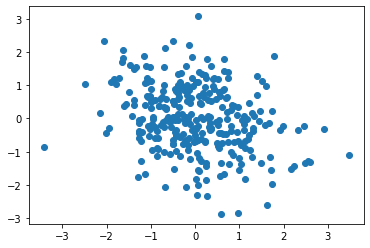

In [ ]:
# download synthetic data

path = '../data/FakeLoan_3var/'
name = 'fakeloan_3var_train.csv'
id = '1Ym0PZIIXRv5G75H50XKgTV_m7n6NtVp7'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id, name, quiet=False)

train = pd.read_csv(name)
sc = StandardScaler()
x_train = sc.fit_transform(train.iloc[:300,:])
y_train = train.iloc[:300,-1].values

x_var = 1e-2


<a name="params"></a>
## Model Parameters

tuning params

(adapted from class material)

In [ ]:
# decoder architecture
input_dim = 4
output_dim = 4
width = 50
hidden_layers = 7
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)
decoder_architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': activation_fn_type,
                'activation_fn': activation_fn,
                'activation_fn_params': None}




# encoder architecture
input_dim = 4
output_dim = 8
width = 50
hidden_layers = 7


encoder_architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': activation_fn_type,
                'activation_fn': activation_fn,
                'activation_fn_params': None}




# prior architecture
input_dim = 8
output_dim = 8 #todo check
width = 12
hidden_layers = 20
# activation_fn_type = 'relu'
# activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

prior_architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': activation_fn_type,
                'activation_fn': activation_fn,
                'activation_fn_params': None}


params = {'step_size':1e-2, 'max_iteration':5000,'random_restarts':1}


train_mask = label_obs_mask
train_mask = random_mask

<a name="training"></a>
## Train Model or load existing

In [ ]:
load = False
if load:
  #load existing weights

  path = '../model_parameters/FakeLoan_3var_generated/'
  name = 'vaeac.decoder.weights.csv'
  id = '1tSpEg1RyQVt2MvZ9d441MnE7W1i9Yp2j'
  if os.path.exists(path + name):
    name = path + name
  else:
    gdown.download('https://drive.google.com/uc?id=' + id, name, quiet=False)
  dweights = load_file(name)


  name = 'vaeac.prior.weights.csv'
  id = '1G6WW4ENb_72QsjqYMAIQ72hsnv5cacJu'
  if os.path.exists(path + name):
    name = path + name
  else:
    gdown.download('https://drive.google.com/uc?id=' + id, name, quiet=False)
  pweights = load_file(name)


  name = 'vaeac.encoder.weights.csv'
  id = '1AwPXdrybpGdhy62fMjtb12g0pOJKL8Rc'
  if os.path.exists(path + name):
    name = path + name
  else:
    gdown.download('https://drive.google.com/uc?id=' + id, name, quiet=False)
  eweights = load_file(name)


  vaeac = VAEAC(prior_architecture, decoder_architecture, encoder_architecture, x_var, train_mask, 
                    prior_weights=pweights, decoder_weights=dweights, encoder_weights=eweights)
  
  mask_test = label_obs_mask(x_test2, 1)

  x = x_test2.T
  m = mask_test.T

  x_hat = vaeac.generate(x, m, weights=dweights, N=x.shape[1])

  x_hat = x_hat + np.random.normal(0, x_var**0.5, size=x_hat.shape)

  fig, ax = plt.subplots(1, 1, figsize=(10, 10))
  ax.scatter(x[0], x[3], color='black', label="original")
  ax.scatter(x_hat[0], x_hat[3], color='blue', alpha=0.5, label="generated")
  plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=12)
  plt.show()

else:
  # train new model
  vaeac = VAEAC(prior_architecture, decoder_architecture, encoder_architecture, x_var, train_mask)
  vaeac.fit(x_train.T, params=params, S=50)

Iteration 0 lower bound 630402.3077764953; gradient mag: 6580654.730479635
Iteration 100 lower bound 55.56835367734356; gradient mag: 305.1709997387098
Iteration 200 lower bound 35.756453049518356; gradient mag: 579.0662445747738
Iteration 300 lower bound 32.24984351601072; gradient mag: 1616.8591393277165
Iteration 400 lower bound 27.685009886081023; gradient mag: 412.3553466557274
Iteration 500 lower bound 27.54435644595738; gradient mag: 1630.007459887516
Iteration 600 lower bound 26.752623220228973; gradient mag: 1590.57710569509
Iteration 700 lower bound 24.906949132451135; gradient mag: 1266.4485353521575
Iteration 800 lower bound 23.79295701871304; gradient mag: 826.5954969342818
Iteration 900 lower bound 22.79761832954985; gradient mag: 329.1740006532002
Iteration 1000 lower bound 22.648903183195962; gradient mag: 560.8253325317195
Iteration 1100 lower bound 21.716133808068392; gradient mag: 525.6489966488222
Iteration 1200 lower bound 22.32431423299175; gradient mag: 664.38612

<a name="test"></a>
## Test (generate data)

In [ ]:
path = '../data/FakeLoan_3var/'
name = 'fakeloan_3var_test.csv'
id = '1-3EUASxhHxuxfWWSidA__YEOjnVrR7EU'
if os.path.exists(path + name):
  name = path + name
else:
  gdown.download('https://drive.google.com/uc?id=' + id, name, quiet=False)

test = pd.read_csv(name)
sc = StandardScaler()
x_test = sc.fit_transform(train.iloc[:300, :])
y_test = train.iloc[:300, -1].values

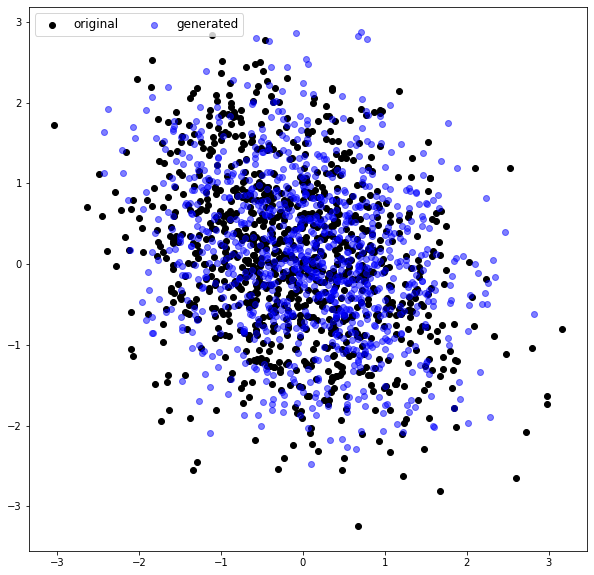

In [ ]:
#Generate Test Data

mask_test = label_obs_mask(x_test, 1)

x = x_test.T
m = mask_test.T

x_hat = vaeac.generate(x, m, N=x.shape[1])

x_hat = x_hat + np.random.normal(0, x_var**0.5, size=x_hat.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(x[0], x[1], color='black', label="original")
ax.scatter(x_hat[0], x_hat[1], color='blue', alpha=0.5, label="generated")
plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=12)
plt.show()


In [ ]:

save_file('vaeac.opt_params.csv', vaeac.opt_params)
save_file('vaeac.decoder.weights.csv', vaeac.decoder.weights)
save_file('vaeac.encoder.weights.csv', vaeac.encoder.weights)
save_file('vaeac.prior.weights.csv', vaeac.prior.weights)

save_file('vaeac_generated_data.csv', x_hat)
save_file('orig_data.csv', x_test)

saved!
saved!
saved!
saved!
saved!
saved!


In [ ]:
# debug
d() 

--Return--
> <ipython-input-4-2a6ee614bd5a>(5)d()->None
-> pdb.set_trace()
